In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# smote resulted in warnings that I don't care about
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = r"C:\Users\zacwa\OneDrive\Documents\Georgia Tech\CDA, CSE-ISYE6740\homework\hw 4\marriage.csv"
# # # this data regarding divorce, divorce (1/0) is in the final column
# # # the features do not have labels which is fine since no analysis is needed here
data = pd.read_csv(file,sep=',',header=None)
m, n = data.shape
X = data.iloc[:,0:(n-1)].copy()
y = data.iloc[:,(n-1)].copy()

print(f'dims of data: {data.shape}')

dims of data: (170, 55)


#### SMOTE
I've decided to do something unecessary but fun for the sake of example. Stochastic gradient descent is developed below. This method is the go to method for very large datasets. The dimensions above indicate that this dataset is quite small in terms of observations. I want to use the same dataset for this so I'll use SMOTE. \
\
Real quick: \
In classification settings an imbalanced response varialbe can result in a high accuracy in testing that is a mirage. An imbalanced dataset may include banking clients scrutinized for a loan. The number of customers who have defaulted in the past will likely be very low, but this is the thing you want to predict with high accuracy. You won't want a lot of false positives as they'll be costly. But with an imbalanced dataset you may have a lot. \
\
Synthetic Minority Oversampling Technique (SMOTE) generates synthetic (read: fake) data that follow the variance of the [real] data you have. I'll use this just to cushion my dataset so it is a bit bigger and so Stochastic Gradient Descent on a tiny dataset doesn't feel so ridiculous. And this is also just an excuse to remind myself of SMOTE and related techniques....\
\
Note : SMOTE is based on nearest neighbors. I'll just use the default K = 5 and assume that's ok to illustrate SGD later below. The assumption of K = 5 may impact testing performance on parameters. \
See here : https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

In [3]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=69,sampling_strategy={0:500,1:500})
X_smote, y_smote = smote.fit_resample(X,y)

In [4]:
X_smote.shape
# y_smote = y.copy()
# X_smote = X.copy()

(1000, 54)

#### Quick Dim Reduction with PCA
The dimensionality is high so I'll preform a quick PCA to get the eigenvectors accounting for 90% or more of variance. Just for fun, I'll use sklearn to quickly get the number of components that comprise 90% or more of the variance. I'll then implement PCA a bit more manually [just for even more fun] with the chosen number of componenets.

24
0.9046913720819335


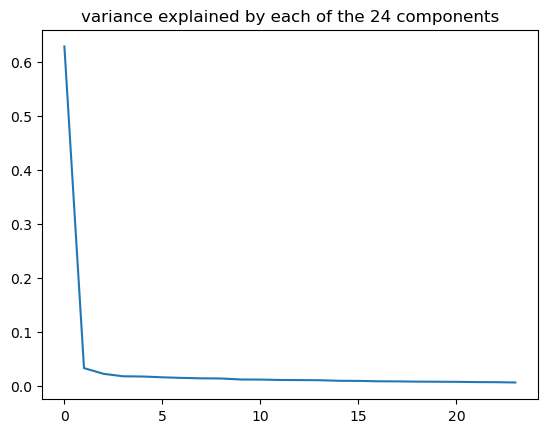

In [5]:
NoComps = np.linspace(2,40,39).astype(int)

for nc in NoComps:
    pca = PCA(n_components=nc).fit(X_smote)
    if np.sum(pca.explained_variance_ratio_) >= 0.899:
        plt.plot(pca.explained_variance_ratio_)
        plt.title(f'variance explained by each of the {nc} components')
        comps = nc
        vectors = pca.components_
        print(nc)
        print(np.sum(pca.explained_variance_ratio_))
        break

Here's a quick (slightly more manual) implementation of PCA using the optimal number of components chosen above. These eigenvectors will be used in the optimization algorithms.

In [6]:
X_smotemu = (X_smote-np.mean(X_smote,axis=0))
C = np.dot(X_smotemu.T,X_smotemu)/m

evl, evc = np.linalg.eig(C)
# remove imaginary elements
evl = evl.real
evc = evc.real
# get the indeX_smote that sorts eigenvalues high to low
idx_sort = np.argsort(evl)[::-1]
# sort and take the first K components that result in 90% of variance
evl = evl[idx_sort][:comps]
evc = evc[:,idx_sort][:,:comps]
# project to reduce dimensions with normalization using eigenvectors
Z = np.array((evc.T@X_smotemu.T).T/np.sqrt(evl))

In [7]:
Z.shape

(1000, 24)

## Optimization

First, I'll implement basic Gradient Descent. It is a straightforward implementation. \
\
Least Squares Regression is a very common objective function for illustrations of convex, unconstrained optimization. \
\
Given the loss function $f(x) = \frac{1}{n}\sum(y-X\beta)^2 $ our objective function is
$ \; f(x)=\frac{1}{2}||y-X\beta||_{2}^{2} $. But this problem does have a convenient closed form solution: \
$ \;\;\;\;\frac{df}{d\beta} = -X^{T}(y-X\beta) $\
$ \;\;\;\;0 = -X^{T}y+X^{T}X\beta $\
$ \;\;\;\;X^{T}X\beta = X^{T}y $ \
$ \;\;\;\;\beta = (X^{T}X)^{-1}X^{T}y $\
\
A basic gradient descent given the gradient \
$ \;\;\;\;\nabla_{x}f(x) = -X^{T}(y-X\beta) $\
will result in the pseudocode

#### initialize $\delta,\beta,\mu$
#### while $||\nabla_{x}f(x)||_{2} >= \delta $
$ \;\;\;\; \beta = \beta - \mu(\nabla_{x}f(x)) $
\
\
But given that there is a convenient closed form solution, it just isn't very interesting to use this function as the example objective function to illustrate optimization. Logisitcs regression, however, does not have a closed form solution. Maximum Likelihood and optimization are used to solve it.

### Logistic Regression Function

The logistic regression problem can be expressed as $ p(y|X) = \frac{1}{1+e^{-\mu}} $\
where $ \mu = \beta_{0}+\beta_{1}x_{1}+...+\beta_{n}x_{n} $. \
and the output $y$ is a Bernouli random variable.\
\
The parameters $\beta$ are taken from the likelihood of the function written in terms of the Bernoulli random variable\
$\;\;\;\; L(\beta;y,X)=\prod^{N}_{i}p(y_{i}|x_{i})^{y_{i}}(1-p(y_{i}|x_{i}))^{1-y_{i}} $ \
which is easier to solve in terms of log-likelihood\
$\;\;\;\; l(\beta;y,X)=\sum^{N}_{i}(-ln(1+exp(x_{i}\beta))+y_{i}x_{i}\beta) = (-ln(1+exp(X\beta))+y^{T}X\beta) $\
\
The MLE form of the problem is \
$\;\;\;\; argmax_{\beta}\sum_{n}^{i}logp(y_{i}|x_{i},\beta)$\
\
Next I'll need the gradient and Hessian \
$\;\;\;\; \nabla_{\beta}l(\beta;y,X)=\sum^{N}_{i}(y_{i}-p(y_{i}|x_{i}))x_{i} = X^{T}(y-\hat{y}) $\
$\;\;\;\; \nabla_{\beta\beta}l(\beta;y,X)=-\sum_{i}^{N}x^{T}_{i}x_{i}p(y_{i}|x_{i})(1-p(y_{i}|x_{i})) = -X^{T}WX $\
where W is an $NxN$ diagonal matrix $i=1...N$ with each $x_{i}$ on the diagnoal 

Details on maths:\
https://www.statlect.com/fundamentals-of-statistics/logistic-model-maximum-likelihood \
ESL, Hastie, Tibshirani, Friedman

In [8]:
def permute_index(m,seed):
    np.random.seed(seed)
    return np.random.permutation(m)

# # # needed functions
def logfunc(Z,B):
    ZB = np.exp(-Z@B)
    return ZB/(1+ZB)

def log_l(ys,X,B,b):
    Z = X[b]
    y = ys[b]
    ZB = np.exp(Z@B)
    ll = np.sum( -np.log(1+ZB) + y.T@Z@B )
    return ll

def grad(ys,X,B,b):
    Z = X[b]
    y = ys[b]
    return Z.T@(y - logfunc(Z,B)) # y_smote - y_smotehat

def Hess(X,B,b):
    Z = X[b]
    W = np.diag(logfunc(Z,B)*(1-logfunc(Z,B)))
    return -Z.T@W@Z

###  Stochastic-Gradient Descent, MiniBatch Method

In [9]:
Zs = shuffle(shuffle(Z,random_state=66),random_state=65)
ysf = shuffle(shuffle(y_smote,random_state=66),random_state=65)

In [10]:
# initializations
m, n = Zs.shape
B = np.zeros(n)

batch_size = 0.2
s = int(m*batch_size)
pi = permute_index(m,1776)
batch_indices = [pi[:s],
           pi[s:s*2],
           pi[s*2:s*3],
           pi[s*3:s*4],
           pi[s*4:s*5]]
y_indices = np.array([i for bi in batch_indices for i in bi])
ys = ysf[y_indices]

initial_b = batch_indices[0]
G0 = grad(ys,Zs,B,initial_b)
H = Hess(Zs,B,initial_b)

u, i, e, tolerance = 0.01, 1, 10, 1e-3
L, error, gradL = [log_l(ys,Zs,B,initial_b)], [], [np.linalg.norm(G0)]

# algo
while e > tolerance:

    # minibatch
    Gs, Ls, Bs = [], [], []
    for ibatch in batch_indices:
        B = B - u*grad(ys,Zs,B,ibatch)
        Gt = grad(ys,Zs,B,ibatch)
        Lt = log_l(ys,Zs,B,ibatch)
        Bs.append(B)
        Gs.append(Gt)
        Ls.append(Lt)
    
    # updates
    B = np.mean(np.stack(Gs,axis=0),axis=0)
    G = np.mean(np.stack(Bs,axis=0),axis=0)
    Lm = np.mean(np.stack(Ls))
    u = u/2**(i-1) # backtracking line search
    i += 1
    e = np.linalg.norm(G-G0)
    
    # collections
    L.append(Lm)
    error.append(e)
    gradL.append(np.linalg.norm(G))
    G0 = G

Text(0.5, 1.0, 'errors over iterations, last error 0.0008533')

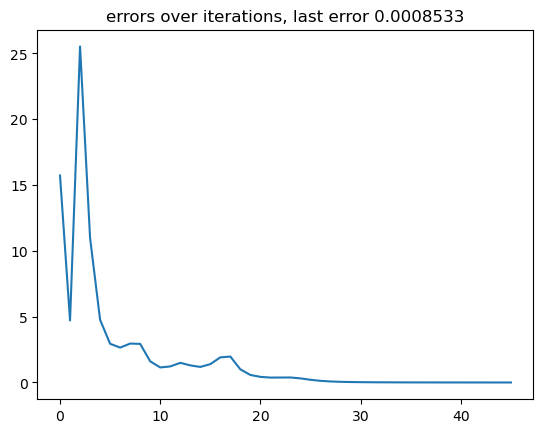

In [11]:
plt.figure()
plt.plot(error)
plt.title(f'errors over iterations, last error {np.round(error[-1],7)}')

Text(0.5, 1.0, 'likelihood fuction over iterations')

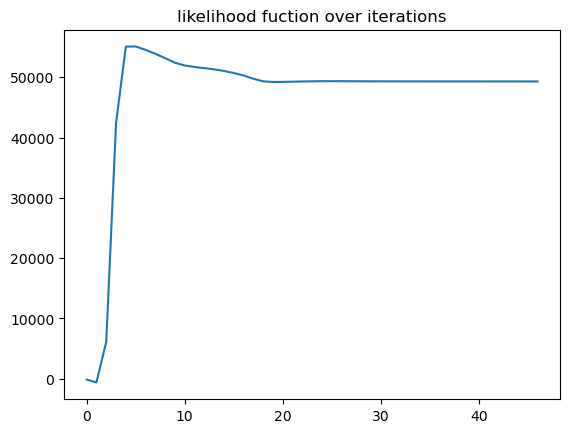

In [12]:
plt.figure()
plt.plot(L)
plt.title('likelihood fuction over iterations')

Text(0.5, 1.0, 'gradient over iterations, last value 42.14434508845621')

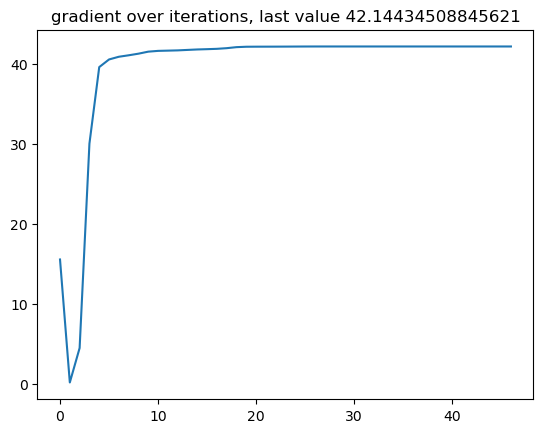

In [13]:
plt.figure()
plt.plot(gradL)
plt.title(f'gradient over iterations, last value {gradL[-1]}')

In [14]:
np.mean(np.where(logfunc(Zs,B)>=0.7,0,1)==ysf)

0.589